In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random

### Modelo

In [26]:
class ModelMLP:
    @staticmethod
    def create_model():
        model = tf.keras.models.Sequential(
            [
                tf.keras.layers.Dense(units=128, activation='relu', input_shape=(784,)),
                tf.keras.layers.Dense(10, activation="softmax")
            ]
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

In [27]:
# Definição dos parâmetros
NUMBER_OF_ROUNDS = 100
TOTAL_CLIENTS = 100
CLIENTS_PER_ROUND = 10

### Cliente

In [28]:
class Client():
    def __init__(self, cid):
        self.cid = int(cid)
        self.model = ModelMLP.create_model()
        self.old_weights = None
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_data()


    def load_data(self):
        path = "./dataset-mnist/non-iid-0.9-100-rotation-45"

        train = pd.read_pickle(f"{path}/{self.cid+1}_train.pickle")
        test = pd.read_pickle(f"{path}/{self.cid+1}_test.pickle")

        x_train = train.drop(['label'], axis=1)
        y_train = train['label']

        x_test = test.drop(['label'], axis=1)
        y_test = test['label']

        return (x_train, y_train), (x_test, y_test)


    def fit(self, parameters, config=None):
        self.model.set_weights(parameters)
        history = self.model.fit(self.x_train, self.y_train, epochs=5, batch_size=128, validation_data=(self.x_test, self.y_test), verbose=False)
        sample_size = len(self.x_train)
        print(f"Acurácia: {history.history['val_accuracy'][-1]} | ")

        if random.random() > 0.68 and self.old_weights is not None:
            print("O modelo não será transmitido!")
            return None

        self.old_weights = self.model.get_weights()
        return self.model.get_weights(), sample_size, {"val_accuracy": history.history['val_accuracy'][-1], 
                                                       "val_loss": history.history['val_loss'][-1]}


    def evaluate(self, parameters):
        self.model.set_weights(parameters)
        return self.model.evaluate(self.x_test, self.y_test, verbose=False)

### Servidor

In [29]:
class Server():
    def __init__(self, n_rounds, total_number_clients, min_fit_clients):
        self.n_rounds = n_rounds
        self.total_number_clients = total_number_clients
        self.min_fit_clients = min_fit_clients

        self.server_round = 0
        self.selected_clients = []
        self.model = ModelMLP.create_model()
        self.w_global = self.model.get_weights()

        self.clients_model_list = []
        # Vamos guardar todos os modelos (pesos) anteriores, mas não é necessário
        self.clients_previous_models_list = [ [] for _ in range(total_number_clients) ]
        self.create_models()
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_data()


    def load_data(self):
        path = "./dataset-mnist/mnist"

        train = pd.read_pickle(f"{path}/train.pickle")
        test = pd.read_pickle(f"{path}/test.pickle")

        x_train = train.drop(['label'], axis=1)
        y_train = train['label']

        # test = pd.concat([test, train])
        x_test = test.drop(['label'], axis=1)
        y_test = test['label']

        return (x_train, y_train), (x_test, y_test)


    def create_models(self):
        for i in range(self.total_number_clients):
            self.clients_model_list.append(Client(i))


    def aggregate_fit(self, weight_list, sample_sizes):
        self.w_global = []
        for weights in zip(*weight_list):
            weighted_sum = 0
            total_samples = sum(sample_sizes)
            for i in range(len(weights)):
                weighted_sum += weights[i] * sample_sizes[i]
            self.w_global.append(weighted_sum / total_samples)


    def configure_fit(self):
        self.selected_clients = np.random.permutation(list(range(self.total_number_clients)))[:self.min_fit_clients]
        print(f"Clientes selecionados: \033[34;1m{np.array(self.selected_clients) + 1}\033[37;0m")

    
    def get_client_previous_model(self, client_id):
        return self.clients_previous_models_list[client_id][-1]


    def save_client_previous_model(self, client_id, model):
        self.clients_previous_models_list[client_id].append(model)


    def fit(self):
        weight_list, sample_sizes_list, info_list, transmissions_count = [], [], [], 0
        for i, pos in enumerate(self.selected_clients):
            print(f"Cliente #{pos+1} | ", end='')

            # Se o cliente decidir não enviar o modelo, ele retorna um None
            new_model = self.clients_model_list[pos].fit(parameters=self.w_global)

            weights, size, info = new_model if new_model is not None else self.get_client_previous_model(pos)
            weight_list.append(weights)
            sample_sizes_list.append(size)
            info_list.append(info)

            # Se o cliente enviou um novo modelo, salve-o e incremente a contagem de transmissões
            if new_model is not None:
                self.save_client_previous_model(pos, (weights, size, info_list))
                transmissions_count += 1

        return weight_list, sample_sizes_list, {"acc_loss_local":[(pos+1, info_list[i]) for i, pos in enumerate(self.selected_clients)]}, transmissions_count


    def distributed_evaluation(self):
        loss_list, accuracy_list = [], []
        for i in range(self.total_number_clients):
            loss, accuracy = self.clients_model_list[i].evaluate(parameters=self.w_global)
            # print(f"Evaluate - CID: {i+1} - accuracy: {accuracy}")
            loss_list.append(loss)
            accuracy_list.append(accuracy)
        return sum(loss_list) / len(loss_list), sum(accuracy_list) / len(accuracy_list), {"accuracy_list": [(i+1, accuracy) for i, accuracy in enumerate(accuracy_list)]}


    def centralized_evaluation(self):
        self.model.set_weights(self.w_global)
        return self.model.evaluate(self.x_test, self.y_test, verbose=False)

### Exemplo de Execução

In [30]:
print('\n' + '='*40)
print("{:^54}".format('\033[;1m' + 'CARREGAMENTO DE DADOS' + '\033[37;0m'))
print("{:^40}".format(f'Número total de clientes: {TOTAL_CLIENTS}' + '\n'))

s = Server(n_rounds=NUMBER_OF_ROUNDS,
           total_number_clients=TOTAL_CLIENTS,
           min_fit_clients=CLIENTS_PER_ROUND)

print('\n' + '='*40)
print("{:^54}".format('\033[;1m' + 'INICIANDO' + '\033[37;0m'))
print("{:^40}".format(f'Clientes por rodada: {CLIENTS_PER_ROUND} ' + '\n'))

evaluate_list = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

transmissions_per_round = []

# Rodadas de comunicação
for s.server_round in range(s.n_rounds):
    print('\033[;1m' + f'Rodada {s.server_round+1}/{s.n_rounds}' + '\033[37;0m')

    # Seleciona os clientes que participarão da próxima rodada de comunicação
    s.configure_fit()

    # Treinamento local do dispositivo
    weight_list, sample_sizes, info, transmissions_count = s.fit()

    # Salva a quantidade de transmissões ocorridas nesta rodada
    transmissions_per_round.append(transmissions_count)

    # Agregação
    s.aggregate_fit(weight_list, sample_sizes)

    # Avaliação centralizada
    print('\033[3;1m' + '-'*40 + '\033[37;0m')
    # print(f"Avaliação centralizada")
    evaluate_loss, evaluate_accuracy = s.centralized_evaluation()
    print(f"Transmissões nesta rodada: {transmissions_count}")
    print(f"Acurácia: {evaluate_accuracy}")
    evaluate_list["centralized"]["loss"].append(evaluate_loss)
    evaluate_list["centralized"]["accuracy"].append(evaluate_accuracy)
    print('\033[3;1m' + '-'*40 + '\033[37;0m' + '\n')

print('\n\n' + '='*40)
print("{:^54}".format('\033[;1m' + 'RESULTADOS FINAIS' + '\033[37;0m'))
print(f"\nCentralized loss: ", end='')
print(evaluate_list["centralized"]["loss"])
print(f"Centralized accuracy: ", end='')
print(evaluate_list["centralized"]["accuracy"])


          CARREGAMENTO DE DADOS           
     Número total de clientes: 100
     


c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in


                INICIANDO                 
       Clientes por rodada: 10 
        
Rodada 1/100
Clientes selecionados: [ 44  13  43 100  48  60  53  38  58  86]
Cliente #44 | Acurácia: 0.9115593433380127 | 
Cliente #13 | Acurácia: 0.931034505367279 | 
Cliente #43 | Acurácia: 0.9215328693389893 | 
Cliente #100 | Acurácia: 0.9126484990119934 | 
Cliente #48 | Acurácia: 0.9304655194282532 | 
Cliente #60 | Acurácia: 0.9286640882492065 | 
Cliente #53 | Acurácia: 0.9138031601905823 | 
Cliente #38 | Acurácia: 0.9204152226448059 | 
Cliente #58 | Acurácia: 0.9378068447113037 | 
Cliente #86 | Acurácia: 0.8912655711174011 | 
----------------------------------------
Transmissões nesta rodada: 10
Acurácia: 0.6657000184059143
----------------------------------------

Rodada 2/100
Clientes selecionados: [10 53 36  3 42 76 62 69 57 60]
Cliente #10 | Acurácia: 0.9390071034431458 | 
Cliente #53 | Acurácia: 0.927198588848114 | 
Cliente #36 | Acurácia: 0.9005059003829956 | 
Cliente #3 | Acurácia: 0.93433

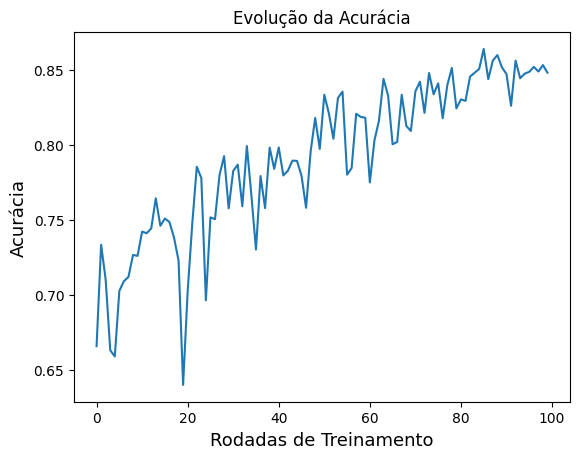

In [31]:
plt.title('Evolução da Acurácia')
plt.plot(evaluate_list["centralized"]["accuracy"])
plt.ylabel('Acurácia', fontsize=13)
plt.xlabel('Rodadas de Treinamento', fontsize=13)
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

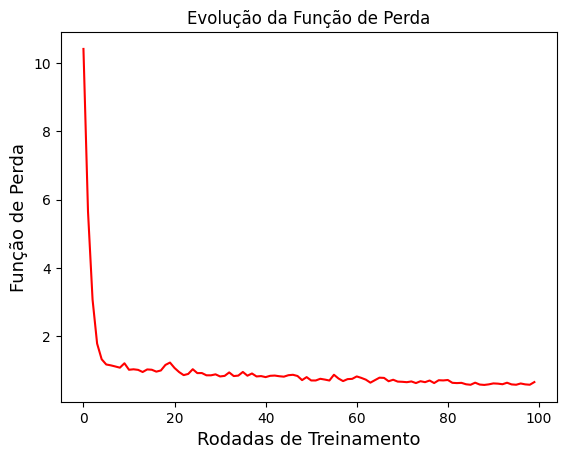

In [32]:
plt.title('Evolução da Função de Perda')
plt.plot(evaluate_list["centralized"]["loss"], color='red')
plt.ylabel('Função de Perda', fontsize=13)
plt.xlabel('Rodadas de Treinamento', fontsize=13)
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

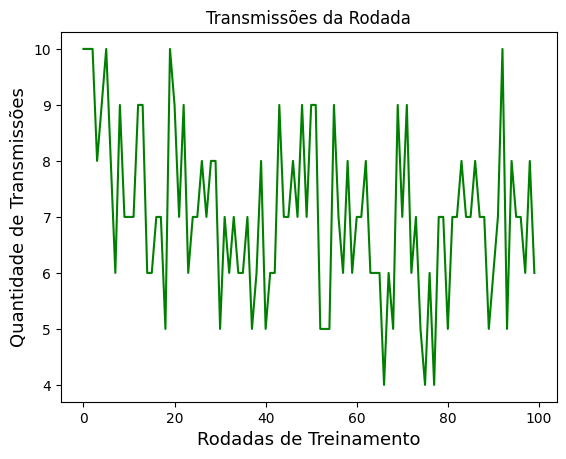

In [33]:
plt.title('Transmissões da Rodada')
plt.plot(transmissions_per_round, color='green',)
plt.ylabel('Quantidade de Transmissões', fontsize=13)
plt.xlabel('Rodadas de Treinamento', fontsize=13)
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

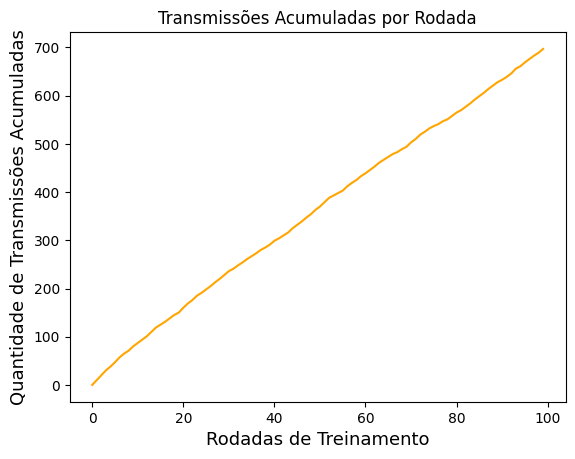

In [34]:
plt.title('Transmissões Acumuladas por Rodada')
plt.plot([sum(transmissions_per_round[0:i]) for i in range(len(transmissions_per_round))], color='orange')
plt.ylabel('Quantidade de Transmissões Acumuladas', fontsize=13)
plt.xlabel('Rodadas de Treinamento', fontsize=13)
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
sum(transmissions_per_round)

703

In [36]:
evaluate_list["centralized"]["accuracy"][-1]

0.8482999801635742